In [3]:
import random
import mldata
import util
import numpy as np
import preprocess
# import previous.dtree
import previous.logreg as logreg
import previous.nbayes as nbayes
from previous.ID3_dtree import ID3DecisionTree 
import sys

# Option 1 is the path to the data as in previous problems.
# Option 2 is a 0/1 option: 
# If 0, use cross validation. 
# If 1, run the algorithm on the full sample. 
# Option 3 is a learning algorithm. 
# This can be dtree, nbayes or logreg. 
# For each value, the base classifier will be the corresponding algorithm you have implemented in your previous assignments. 
# You should use the decision stumps (trees of depth 1, containing just the root), for the dtree option. 
# All parameters for these base classifiers should be “reasonable” values, i.e. use
# values that you have previously found to work well with these algorithms.
# Option 4 is the number of iterations to perform boosting

# Remember that for boosting, you will need to modify your previous code so it works with weighted
# examples. Some of these modifications were described in class.

def create_for_train(X_data, y_data, folds, n_bin, index):
    if n_bin == 1:
        return X_data, y_data, X_data, y_data
    else:
        x_train = []
        y_train = []
        x_test = folds[index]
        y_test = folds[index]
        for i in range(n_bin):
            if i == index:
                continue
            x_train.extend(folds[i])
            y_train.extend(folds[i])

        return X_data[x_train, :], y_data[y_train], X_data[x_test, :], y_data[y_test]

def boost(path, option, solver_type, num_iters): 
    path = path.replace("\\", "/")
    file_base = path.split('/')[-1]
    rootdir=path

    epsilon_thread = 0.00000001

    data = mldata.parse_c45(file_base, rootdir)
    n_bin = 1
    cross_validation = False
    if option == 0:
        n_bin = 5
        cross_validation = True

    data = np.asarray(data.to_float())
    X_data = data[:, 1:-1]
    X_data = preprocess.process(X_data, file_base, n_bin)
    y_data = data[:, -1].astype(int)
    # print(len(X_data))
    # partition the data into multiple dataset,
    folds = util.n_fold(len(data), n_bin)

    # nbayes:
    posi_num = [{} for i in range(len(X_data[0]))]
    nega_num = [{} for i in range(len(X_data[0]))]
            
    for i, d in enumerate(posi_num):
        for attr in np.unique(X_data[:, i]):
            posi_num[i][attr] = 0
                    
    for i, d in enumerate(nega_num):
        for attr in np.unique(X_data[:, i]):
            nega_num[i][attr] = 0

    AUC_y = []
    pred_AUC_y = []
    acc = []
    prec = []
    rec = []
    # training and evaluating
                
    for i in range(n_bin):
        if solver_type == "dtree":
            tree = ID3DecisionTree(1, path, "gain", cross_validation)
            x_train, y_train, x_test, y_test = tree.create_for_train(n_bin, i)
            train_size = len(x_train)
            wboost = np.ones((train_size, 1)).astype(float)/train_size
            alphas = []
            epsilons = []
            forest = []
            for iter_ in range(num_iters): 
                tree = ID3DecisionTree(1, path, "gain", cross_validation)
                x_train, y_train, x_test, y_test = tree.create_for_train(n_bin, i)
                D_train = (x_train, y_train)
                wboost, epsilon, alpha = tree.boosttrain(D_train, wboost, epsilon_thread)
                forest.append(tree)
                epsilons.append(epsilon)
                if epsilon == 0:
                    alphas = [0] * len(alphas)
                    alphas.append(1)
                    break
                elif epsilon <= epsilon_thread or epsilon >= 0.5:
                    alphas.append(alpha)
                    break
                else:
                    alphas.append(alpha)
                # y_pred = tree.test(x_test)
            result = []
            for i in range(len(forest)):
                y_predB = forest[i].test(x_test)
                y_pred = np.array(y_predB)
                y_pred[y_pred==False] = 0
                y_pred[y_pred==True] = 1
                result.append(y_pred)
            alphas = np.array(alphas)
            alphas = alphas/np.sum(alphas)
            y_pred = alphas.dot(np.array(result))
            y_pred[y_pred<0.5] = 0
            y_pred[y_pred>=0.5] = 1
            y_test = np.array(y_test)
            y_test[y_test<0.5] = 0
            y_test[y_test>=0.5] = 1
            AUC_y.extend(y_test)
            pred_AUC_y.extend(y_pred)
            _acc, _prec, _rec = util.cal_APR(y_pred, y_test)
            if cross_validation:
                util.report_cross(_acc, _prec, _rec)
            acc.append(_acc)
            prec.append(_prec)
            rec.append(_rec)
        elif solver_type == "nbayes":
            m_etimate = 0.1
            x_train, y_train, x_test, y_test = create_for_train(X_data, y_data, folds, n_bin, i)
            train_size = len(x_train)
            wboost = np.ones((train_size, 1)).astype(float)/train_size
            alphas = []
            epsilons = []
            pre_ps = []
            posi_ps = []
            nega_ps = []
            for iter_ in range(num_iters): 
                pre_p, posi_p, nega_p, epsilon, alpha, wboost = nbayes.boosttrain_bayes(x_train, y_train, m_etimate, posi_num, nega_num, wboost, epsilon_thread)
                epsilons.append(epsilon)
                pre_ps.append(pre_p)
                posi_ps.append(posi_p)
                nega_ps.append(nega_p)
                if epsilon == 0:
                    alphas = [0] * len(alphas)
                    alphas.append(1)
                    break
                elif epsilon <= epsilon_thread or epsilon >= 0.5:
                    alphas.append(alpha)
                    break
                else:
                    alphas.append(alpha)
            result = []
            for i in range(len(pre_ps)):
                y_predB = nbayes.pred(x_test, pre_ps[i], posi_ps[i], nega_ps[i])
                y_pred = []
                for i in y_predB:
                    if i[0] > i[1]:
                        y_pred.append(0)
                    else:
                        y_pred.append(1)
                y_pred = np.array(y_pred)
                result.append(y_pred)
            alphas = np.array(alphas)
            alphas = alphas/np.sum(alphas)
            y_pred = alphas.dot(np.array(result))
            y_pred[y_pred<0.5] = 0
            y_pred[y_pred>=0.5] = 1
            AUC_y.extend(y_test)
            pred_AUC_y.extend(y_pred)
            _acc, _prec, _rec = util.cal_APR(y_pred, y_test)
            if cross_validation:
                util.report_cross(_acc, _prec, _rec)
            acc.append(_acc)
            prec.append(_prec)
            rec.append(_rec)
        elif solver_type == "logreg":
            # train
            x_train, y_train, x_test, y_test = create_for_train(X_data, y_data, folds, n_bin, i)
            train_size = len(x_train)
            wboost = np.ones((train_size, 1)).astype(float)/train_size
            alphas = []
            epsilons = []
            weights = []
            for iter_ in range(num_iters): 
                weight, epsilon, alpha, wboost = logreg.boostLR(x_train, y_train, wboost, epsilon_thread, max_iters=500, lbd=0.1)
                epsilons.append(epsilon)
                weights.append(weight)
                if epsilon == 0:
                    alphas = [0] * len(alphas)
                    alphas.append(1)
                    break
                elif epsilon <= epsilon_thread or epsilon >= 0.5:
                    alphas.append(alpha)
                    break
                else:
                    alphas.append(alpha)
            result = []
            for i in range(len(weights)):
                result.append(logreg.pred(x_test, weights[i]))
            alphas = np.array(alphas)
            alphas = alphas/np.sum(alphas)
            y_pred = alphas.dot(np.array(result))
            y_pred[y_pred<0.5] = 0
            y_pred[y_pred>=0.5] = 1
            AUC_y.extend(y_test)
            pred_AUC_y.extend(y_pred)
            _acc, _prec, _rec = logreg.cal_LR_APR(y_pred, y_test)
            if cross_validation:
                util.report_cross(_acc, _prec, _rec)
            acc.append(_acc)
            prec.append(_prec)
            rec.append(_rec)
        else:
            return 
    roc_score = logreg.cal_AUC(AUC_y, pred_AUC_y)
    util.report(acc, prec, rec, roc_score)
    if type(acc) is list:
        return np.mean(acc), np.mean(prec), np.mean(rec), roc_score
    return acc, prec, rec, roc_score
# When your code is run, it should first construct 5 folds using stratified cross validation if this option is
# provided. To ensure repeatability, set the random seed for the PRNG to 12345. Then it should produce
# boosted models on each fold (or the sample according to the option)

# Accuracy: 0.xyz 0.abc
# Precision: 0.xyz 0.abc
# Recall: 0.xyz 0.abc
# Area under ROC: 0.xyz
# “0.xyz” is the average value of each quantity over five folds.
# “0.abc” is the standard deviation. 
# For Area under ROC, use the “pooling” method described in problem 2.
# from util import *

In [7]:
spam_logreg = []
volcanoes_logreg = []
spam_nbayes = []
volcanoes_nbayes = []
random.seed(12345)
spam_logreg.append(boost("440data/spam", 0, "logreg", 2)) 
random.seed(12345)
spam_logreg.append(boost("440data/spam", 0, "logreg", 10))
random.seed(12345)
spam_logreg.append(boost("440data/spam", 0, "logreg", 50))
random.seed(12345)
volcanoes_logreg.append(boost("440data/volcanoes", 0, "logreg", 2))
random.seed(12345)
volcanoes_logreg.append(boost("440data/volcanoes", 0, "logreg", 10))
random.seed(12345)
volcanoes_logreg.append(boost("440data/volcanoes", 0, "logreg", 50))
random.seed(12345)
spam_nbayes.append(boost("440data/spam", 0, "nbayes", 2))
random.seed(12345)
spam_nbayes.append(boost("440data/spam", 0, "nbayes", 10))
random.seed(12345)
spam_nbayes.append(boost("440data/spam", 0, "nbayes", 50))
random.seed(12345)
volcanoes_nbayes.append(boost("440data/volcanoes", 0, "nbayes", 2))
random.seed(12345)
volcanoes_nbayes.append(boost("440data/volcanoes", 0, "nbayes", 10))
random.seed(12345)
volcanoes_nbayes.append(boost("440data/volcanoes", 0, "nbayes", 50))

===============Fold report==================
Accuracy:0.694
Precision:0.692
Recall:0.917
===============Fold report==================
Accuracy:0.628
Precision:0.627
Recall:0.999
===============Fold report==================
Accuracy:0.514
Precision:0.942
Recall:0.246
===============Fold report==================
Accuracy:0.513
Precision:0.962
Recall:0.220
===============Fold report==================
Accuracy:0.629
Precision:0.629
Recall:1.000
===============Final report=================
Accuracy:0.596 0.071
Precision:0.770 0.150
Recall:0.677 0.363
Area under ROC 0.074
===============Fold report==================
Accuracy:0.694
Precision:0.692
Recall:0.917
===============Fold report==================
Accuracy:0.628
Precision:0.627
Recall:0.999
===============Fold report==================
Accuracy:0.514
Precision:0.942
Recall:0.246
===============Fold report==================
Accuracy:0.513
Precision:0.962
Recall:0.220
===============Fold report==================
Accuracy:0.629
Precision:0

In [9]:
spam_dtree = []
volcanoes_dtree = []
random.seed(12345)
spam_dtree.append(boost("440data/voting", 0, "dtree", 2))
random.seed(12345)
spam_dtree.append(boost("440data/voting", 0, "dtree", 10))
random.seed(12345)
spam_dtree.append(boost("440data/voting", 0, "dtree", 50))
random.seed(12345)
volcanoes_dtree.append(boost("440data/volcanoes", 0, "dtree", 2))
random.seed(12345)
volcanoes_dtree.append(boost("440data/volcanoes", 0, "dtree", 10))
random.seed(12345)
volcanoes_dtree.append(boost("440data/volcanoes", 0, "dtree", 50))

===============Fold report==================
Accuracy:1.000
Precision:1.000
Recall:1.000
===============Fold report==================
Accuracy:0.989
Precision:0.980
Recall:1.000
===============Fold report==================
Accuracy:0.989
Precision:0.980
Recall:1.000
===============Fold report==================
Accuracy:0.989
Precision:0.980
Recall:1.000
===============Fold report==================
Accuracy:1.000
Precision:1.000
Recall:1.000
===============Final report=================
Accuracy:0.993 0.006
Precision:0.988 0.010
Recall:1.000 0.000
Area under ROC 0.000
===============Fold report==================
Accuracy:1.000
Precision:1.000
Recall:1.000
===============Fold report==================
Accuracy:0.989
Precision:0.980
Recall:1.000
===============Fold report==================
Accuracy:0.989
Precision:0.980
Recall:1.000
===============Fold report==================
Accuracy:0.989
Precision:0.980
Recall:1.000
===============Fold report==================
Accuracy:1.000
Precision:1

[(0.5957356730557685, 0.7704861770220492, 0.6765340054950781, 0.07431591111897175), (0.5957356730557685, 0.7704861770220492, 0.6765340054950781, 0.07431591111897175), (0.5957356730557685, 0.7704861770220492, 0.6765340054950781, 0.07431591111897175)]
[(0.7360359546954787, 0.6652377106084651, 0.6708764227846549, 0.1259644322845417), (0.7360359546954787, 0.6652377106084651, 0.6708764227846549, 0.1259644322845417), (0.7360359546954787, 0.6652377106084651, 0.6708764227846549, 0.1259644322845417)]


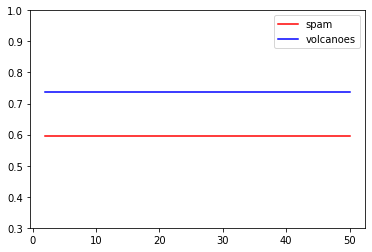

[(0.7012551529184226, 0.7460064008284102, 0.7918641378382423, 0.057226095652341484), (0.7020981081687989, 0.7450640331377569, 0.7959760579675513, 0.05562652616858648), (0.7022452948952322, 0.7450260632350083, 0.7964013184395904, 0.05547712627280872)]
[(0.6311042224696782, 0.4633413054006478, 0.7995069602565564, 0.05479160966712266), (0.6140698829265356, 0.45148616144252723, 0.832429093568483, 0.04233561331509348), (0.6140708861267443, 0.4515715759556665, 0.8338889475830815, 0.041933424532603736)]


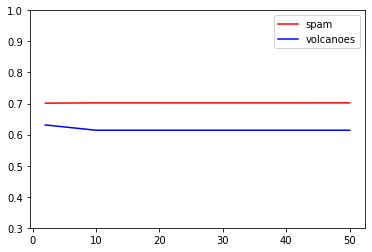

[(0.9931034482758619, 0.9877551020408163, 1.0, 0.0), (0.9931034482758619, 0.9877551020408163, 1.0, 0.0), (0.9931034482758619, 0.9877551020408163, 1.0, 0.0)]
[(0.6399103139013453, 0.6750786177976819, 0.8986666666666668, 0.00548310502283105), (0.6399103139013453, 0.6750786177976819, 0.8986666666666668, 0.00548310502283105), (0.6399103139013453, 0.6750786177976819, 0.8986666666666668, 0.00548310502283105)]


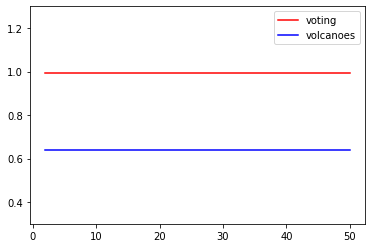

In [21]:
# b. Pick at least three iteration values between 2 and 50
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

x_label = [2, 10, 50]

print(spam_logreg)
print(volcanoes_logreg)
acc_spam = list(map(lambda x:x[0], spam_logreg))
acc_volcanoes = list(map(lambda x:x[0], volcanoes_logreg))
plt.figure()
plt.plot(x_label, acc_spam, c='red', label = "spam")
plt.plot(x_label, acc_volcanoes, c='blue', label = "volcanoes")
plt.ylim(0.3, 1)
plt.legend()
plt.show()

print(spam_nbayes)
print(volcanoes_nbayes)
acc_spam = list(map(lambda x:x[0], spam_nbayes))
acc_volcanoes = list(map(lambda x:x[0], volcanoes_nbayes))
plt.figure()
plt.plot(x_label, acc_spam, c='red', label = "spam")
plt.plot(x_label, acc_volcanoes, c='blue', label = "volcanoes")
plt.ylim(0.3, 1)
plt.legend()
plt.show()


print(spam_dtree)
print(volcanoes_dtree)
acc_spam = list(map(lambda x:x[0], spam_dtree))
acc_volcanoes = list(map(lambda x:x[0], volcanoes_dtree))
plt.figure()
plt.plot(x_label, acc_spam, c='red', label = "voting")
plt.plot(x_label, acc_volcanoes, c='blue', label = "volcanoes")
plt.ylim(0.3, 1.3)
plt.legend()
plt.show()




(a) When compared to our pervious results of using the base learner, 
1. dtree
   - boosting does not improve the accuracy in voting and volcanoes dataset. Maybe these two datasets are small.
2. nbayes
   - boosting increases the accuracy from 63.2% to 63.9% on volcanoes dataset, while the accuracy reduced from 70.8% to 70.2% on spam dataset. The precision increases from 74.4% to 74.6% on spam dataset.
3. logreg
   - boosting increases the accuracy from 73.5% to 73.6% on volcanoes dataset, while the accuracy reduced from 60.5% to 59.6% on spam dataset. The recall increases from 60.1% to 67.7% on spam dataset.

(b) We found the number of itertaions does not take much efferts on improving the accuracy. Although we have observed **decreasing epsilon** with increasing iterations, it seems the accuracy remains.



In [22]:
def boost(path, option, solver_type, num_iters, input_epsilon): 
    path = path.replace("\\", "/")
    file_base = path.split('/')[-1]
    rootdir=path

    epsilon_thread = input_epsilon

    data = mldata.parse_c45(file_base, rootdir)
    n_bin = 1
    cross_validation = False
    if option == 0:
        n_bin = 5
        cross_validation = True

    data = np.asarray(data.to_float())
    X_data = data[:, 1:-1]
    X_data = preprocess.process(X_data, file_base, n_bin)
    y_data = data[:, -1].astype(int)
    # print(len(X_data))
    # partition the data into multiple dataset,
    folds = util.n_fold(len(data), n_bin)

    # nbayes:
    posi_num = [{} for i in range(len(X_data[0]))]
    nega_num = [{} for i in range(len(X_data[0]))]
            
    for i, d in enumerate(posi_num):
        for attr in np.unique(X_data[:, i]):
            posi_num[i][attr] = 0
                    
    for i, d in enumerate(nega_num):
        for attr in np.unique(X_data[:, i]):
            nega_num[i][attr] = 0

    AUC_y = []
    pred_AUC_y = []
    acc = []
    prec = []
    rec = []
    # training and evaluating
                
    for i in range(n_bin):
        if solver_type == "dtree":
            tree = ID3DecisionTree(1, path, "gain", cross_validation)
            x_train, y_train, x_test, y_test = tree.create_for_train(n_bin, i)
            train_size = len(x_train)
            wboost = np.ones((train_size, 1)).astype(float)/train_size
            alphas = []
            epsilons = []
            forest = []
            for iter_ in range(num_iters): 
                tree = ID3DecisionTree(1, path, "gain", cross_validation)
                x_train, y_train, x_test, y_test = tree.create_for_train(n_bin, i)
                D_train = (x_train, y_train)
                wboost, epsilon, alpha = tree.boosttrain(D_train, wboost, epsilon_thread)
                forest.append(tree)
                epsilons.append(epsilon)
                if epsilon == 0:
                    alphas = [0] * len(alphas)
                    alphas.append(1)
                    break
                elif epsilon <= epsilon_thread or epsilon >= 0.5:
                    alphas.append(alpha)
                    break
                else:
                    alphas.append(alpha)
                # y_pred = tree.test(x_test)
            result = []
            for i in range(len(forest)):
                y_predB = forest[i].test(x_test)
                y_pred = np.array(y_predB)
                y_pred[y_pred==False] = 0
                y_pred[y_pred==True] = 1
                result.append(y_pred)
            alphas = np.array(alphas)
            alphas = alphas/np.sum(alphas)
            y_pred = alphas.dot(np.array(result))
            y_pred[y_pred<0.5] = 0
            y_pred[y_pred>=0.5] = 1
            y_test = np.array(y_test)
            y_test[y_test<0.5] = 0
            y_test[y_test>=0.5] = 1
            AUC_y.extend(y_test)
            pred_AUC_y.extend(y_pred)
            _acc, _prec, _rec = util.cal_APR(y_pred, y_test)
            if cross_validation:
                util.report_cross(_acc, _prec, _rec)
            acc.append(_acc)
            prec.append(_prec)
            rec.append(_rec)
        elif solver_type == "nbayes":
            m_etimate = 0.1
            x_train, y_train, x_test, y_test = create_for_train(X_data, y_data, folds, n_bin, i)
            train_size = len(x_train)
            wboost = np.ones((train_size, 1)).astype(float)/train_size
            alphas = []
            epsilons = []
            pre_ps = []
            posi_ps = []
            nega_ps = []
            for iter_ in range(num_iters): 
                pre_p, posi_p, nega_p, epsilon, alpha, wboost = nbayes.boosttrain_bayes(x_train, y_train, m_etimate, posi_num, nega_num, wboost, epsilon_thread)
                epsilons.append(epsilon)
                pre_ps.append(pre_p)
                posi_ps.append(posi_p)
                nega_ps.append(nega_p)
                if epsilon == 0:
                    alphas = [0] * len(alphas)
                    alphas.append(1)
                    break
                elif epsilon <= epsilon_thread or epsilon >= 0.5:
                    alphas.append(alpha)
                    break
                else:
                    alphas.append(alpha)
            result = []
            for i in range(len(pre_ps)):
                y_predB = nbayes.pred(x_test, pre_ps[i], posi_ps[i], nega_ps[i])
                y_pred = []
                for i in y_predB:
                    if i[0] > i[1]:
                        y_pred.append(0)
                    else:
                        y_pred.append(1)
                y_pred = np.array(y_pred)
                result.append(y_pred)
            alphas = np.array(alphas)
            alphas = alphas/np.sum(alphas)
            y_pred = alphas.dot(np.array(result))
            y_pred[y_pred<0.5] = 0
            y_pred[y_pred>=0.5] = 1
            AUC_y.extend(y_test)
            pred_AUC_y.extend(y_pred)
            _acc, _prec, _rec = util.cal_APR(y_pred, y_test)
            if cross_validation:
                util.report_cross(_acc, _prec, _rec)
            acc.append(_acc)
            prec.append(_prec)
            rec.append(_rec)
        elif solver_type == "logreg":
            # train
            x_train, y_train, x_test, y_test = create_for_train(X_data, y_data, folds, n_bin, i)
            train_size = len(x_train)
            wboost = np.ones((train_size, 1)).astype(float)/train_size
            alphas = []
            epsilons = []
            weights = []
            for iter_ in range(num_iters): 
                weight, epsilon, alpha, wboost = logreg.boostLR(x_train, y_train, wboost, epsilon_thread, max_iters=500, lbd=0.1)
                epsilons.append(epsilon)
                weights.append(weight)
                if epsilon == 0:
                    alphas = [0] * len(alphas)
                    alphas.append(1)
                    break
                elif epsilon <= epsilon_thread or epsilon >= 0.5:
                    alphas.append(alpha)
                    break
                else:
                    alphas.append(alpha)
            result = []
            for i in range(len(weights)):
                result.append(logreg.pred(x_test, weights[i]))
            alphas = np.array(alphas)
            alphas = alphas/np.sum(alphas)
            y_pred = alphas.dot(np.array(result))
            y_pred[y_pred<0.5] = 0
            y_pred[y_pred>=0.5] = 1
            AUC_y.extend(y_test)
            pred_AUC_y.extend(y_pred)
            _acc, _prec, _rec = logreg.cal_LR_APR(y_pred, y_test)
            if cross_validation:
                util.report_cross(_acc, _prec, _rec)
            acc.append(_acc)
            prec.append(_prec)
            rec.append(_rec)
        else:
            return 
    roc_score = logreg.cal_AUC(AUC_y, pred_AUC_y)
    util.report(acc, prec, rec, roc_score)
    if type(acc) is list:
        return np.mean(acc), np.mean(prec), np.mean(rec), roc_score
    return acc, prec, rec, roc_score

research_ext = []

random.seed(12345)
research_ext.append(boost("440data/volcanoes", 0, "nbayes", 50, 0.3))
research_ext.append(boost("440data/volcanoes", 0, "nbayes", 50, 0.1))
research_ext.append(boost("440data/volcanoes", 0, "nbayes", 50, 0.00000001))


===============Fold report==================
Accuracy:0.638
Precision:0.488
Recall:0.801
===============Fold report==================
Accuracy:0.601
Precision:0.419
Recall:0.774
===============Fold report==================
Accuracy:0.650
Precision:0.487
Recall:0.866
===============Fold report==================
Accuracy:0.626
Precision:0.458
Recall:0.795
===============Fold report==================
Accuracy:0.643
Precision:0.466
Recall:0.762
===============Final report=================
Accuracy:0.632 0.017
Precision:0.464 0.025
Recall:0.800 0.036
Area under ROC 0.055
===============Fold report==================
Accuracy:0.642
Precision:0.486
Recall:0.810
===============Fold report==================
Accuracy:0.626
Precision:0.458
Recall:0.861
===============Fold report==================
Accuracy:0.601
Precision:0.437
Recall:0.735
===============Fold report==================
Accuracy:0.650
Precision:0.463
Recall:0.812
===============Fold report==================
Accuracy:0.632
Precision:0

[(0.6315526529629517, 0.46367120487467595, 0.7995069602565564, 0.05485818513451892), (0.6302053550827139, 0.4628030976560307, 0.8019606033250767, 0.05421796625626995), (0.6131780379410319, 0.45065536714491217, 0.8324576728931448, 0.04222435020519836)]


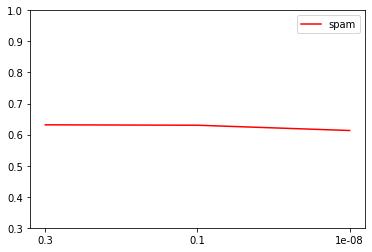

In [25]:
print(research_ext)
x_label = [0.3, 0.1, 0.00000001]
plt.figure()
research_acc = list(map(lambda x:x[0], research_ext))
plt.plot(range(3), research_acc, c='red', label = "spam")
plt.xticks(range(3), x_label)
plt.ylim(0.3, 1)
plt.legend()
plt.show()

(c) Research extension

We change the epsilon threadholds: 0.3, 0.1, and 0.00000001 to see whether epsilon threadhold can affect the accuracy.

We found the accuracy dropped when the threhold of the epsilon is small (1e-8), so searching for an adaptive epsilon is very important to acquire a good accuracy.